<a href="https://colab.research.google.com/github/alizehadeel/AI-ML-Notebook/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Assignment: Multiclass Text Classification — Student Task

**Problem statement:**

You are given a CSV dataset that contains **text data** and two numeric features. The dataset contains **missing values** and artificially injected **numeric outliers**. Your task is to implement a full ML pipeline that:

1. Loads the CSV file.
2. Performs EDA to show missing values, class balance and numeric distributions.
3. Imputes missing values (text and numeric), encodes text using TF-IDF, encodes labels, and scales numeric features.
4. Detects and removes numeric outliers using the IQR method (report rows removed).
5. Trains and evaluates **Logistic Regression, SVM, KNN, Decision Tree, Random Forest** for **multi-class** classification.
6. For each model, compute the **confusion matrix** and **classification report** (precision/recall/F1 per class).
7. Produce a **comparison table and plot** of macro-averaged Precision, Recall, F1 and Accuracy across models and discuss results.

**Dataset (local path):** `/mnt/data/multiclass_text_problem_dataset.csv`

Run each cell in order. Students should add short markdown notes explaining their choices and observations after each major section.


## 1. Imports

In [ ]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from scipy.sparse import hstack, csr_matrix

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 2. Load dataset

In [ ]:
# Load CSV dataset
path = r"multiclass_text_problem_dataset.csv"
df = pd.read_csv(path)
print('Dataset shape:', df.shape)
df.head()

Dataset shape: (600, 4)


,text,num_feat_1,num_feat_2,label
0,season opener sees great performance by rookie...,44.967625,7.090626,sports
1,new smartphone release features better battery...,44.820873,5.482097,technology
2,doctor recommends balanced diet and sleep devi...,49.727101,4.465488,health
3,coach discusses strategy and training network ...,52.019074,3.390527,sports
4,election debates heat up over economy and law ...,54.933179,5.369672,politics


## 3. Quick EDA

Missing values per column:
 text          29
num_feat_1    34
num_feat_2     0
label          0
dtype: int64

Class distribution:
 sports        150
technology    150
health        150
politics      150
Name: label, dtype: int64


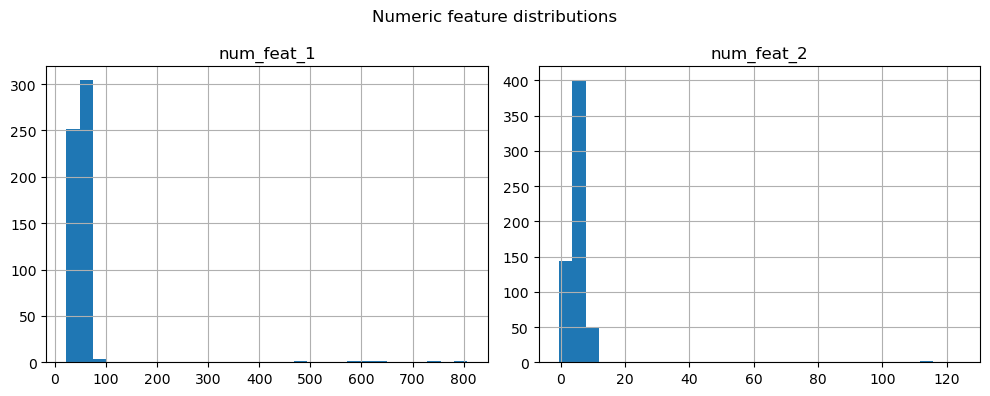

In [ ]:
print('Missing values per column:\n', df.isna().sum())
print('\nClass distribution:\n', df['label'].value_counts())

df[['num_feat_1','num_feat_2']].describe()

# Histograms
_df = df.copy()
_df[['num_feat_1','num_feat_2']].hist(bins=30, figsize=(10,4))
plt.suptitle('Numeric feature distributions')
plt.tight_layout()
plt.show()

## 4. Handle missing values (imputation)

In [ ]:
df_prep = df.copy()
# Text: fillna with placeholder
df_prep['text'] = df_prep['text'].fillna('missing_text')
# Numeric: median imputation
num_imputer = SimpleImputer(strategy='median')
df_prep[['num_feat_1','num_feat_2']] = num_imputer.fit_transform(df_prep[['num_feat_1','num_feat_2']])
print('After imputation missing counts:\n', df_prep.isna().sum())
df_prep.head()

After imputation missing counts:
 text          0
num_feat_1    0
num_feat_2    0
label         0
dtype: int64


,text,num_feat_1,num_feat_2,label
0,season opener sees great performance by rookie...,44.967625,7.090626,sports
1,new smartphone release features better battery...,44.820873,5.482097,technology
2,doctor recommends balanced diet and sleep devi...,49.727101,4.465488,health
3,coach discusses strategy and training network ...,52.019074,3.390527,sports
4,election debates heat up over economy and law ...,54.933179,5.369672,politics


## 5. Detect and remove numeric outliers using IQR

In [ ]:
numeric_features = ['num_feat_1','num_feat_2']
Q1 = df_prep[numeric_features].quantile(0.25)
Q3 = df_prep[numeric_features].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
mask = ~((df_prep[numeric_features] < lower) | (df_prep[numeric_features] > upper)).any(axis=1)
print('Rows before outlier removal:', df_prep.shape[0])
df_no_out = df_prep[mask].copy()
print('Rows after outlier removal:', df_no_out.shape[0], 'removed', df_prep.shape[0]-df_no_out.shape[0], 'rows')


Rows before outlier removal: 600
Rows after outlier removal: 588 removed 12 rows


## 6. Preprocessing: TF-IDF for text, label encoding, scaling numeric features

In [ ]:
# TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
X_text = vectorizer.fit_transform(df_no_out['text'].values.astype('U'))
# Scale numeric
scaler = StandardScaler()
X_num = scaler.fit_transform(df_no_out[['num_feat_1','num_feat_2']])
X_num_sparse = csr_matrix(X_num)
# Combine
X = hstack([X_text, X_num_sparse])
# Labels
le = LabelEncoder()
y = le.fit_transform(df_no_out['label'])
print('X shape:', X.shape)
print('Classes:', le.classes_)


X shape: (588, 418)
Classes: ['health' 'politics' 'sports' 'technology']


## 7. Train-test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


Train shape: (470, 418) Test shape: (118, 418)


## 8. Train models and evaluate (multi-class)

In [ ]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'SVM': SVC(probability=True, random_state=RANDOM_STATE),
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
}

results = []

for name, model in models.items():
    print('\n===== {} ====='.format(name))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Classification report:\n', classification_report(y_test, y_pred, target_names=le.classes_))
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion matrix:\n', cm)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    results.append({'model': name, 'accuracy': acc, 'precision_macro': prec, 'recall_macro': rec, 'f1_macro': f1})



===== LogisticRegression =====
Classification report:
               precision    recall  f1-score   support

      health       1.00      0.97      0.98        29
    politics       0.91      1.00      0.95        29
      sports       1.00      0.93      0.97        30
  technology       0.97      0.97      0.97        30

    accuracy                           0.97       118
   macro avg       0.97      0.97      0.97       118
weighted avg       0.97      0.97      0.97       118

Confusion matrix:
 [[28  1  0  0]
 [ 0 29  0  0]
 [ 0  1 28  1]
 [ 0  1  0 29]]

===== SVM =====
Classification report:
               precision    recall  f1-score   support

      health       1.00      0.97      0.98        29
    politics       0.91      1.00      0.95        29
      sports       1.00      0.97      0.98        30
  technology       1.00      0.97      0.98        30

    accuracy                           0.97       118
   macro avg       0.98      0.97      0.97       118
weighted

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Classification report:
               precision    recall  f1-score   support

      health       1.00      0.97      0.98        29
    politics       0.91      1.00      0.95        29
      sports       1.00      0.93      0.97        30
  technology       0.97      0.97      0.97        30

    accuracy                           0.97       118
   macro avg       0.97      0.97      0.97       118
weighted avg       0.97      0.97      0.97       118

Confusion matrix:
 [[28  1  0  0]
 [ 0 29  0  0]
 [ 0  1 28  1]
 [ 0  1  0 29]]


## 9. Comparison table and plot

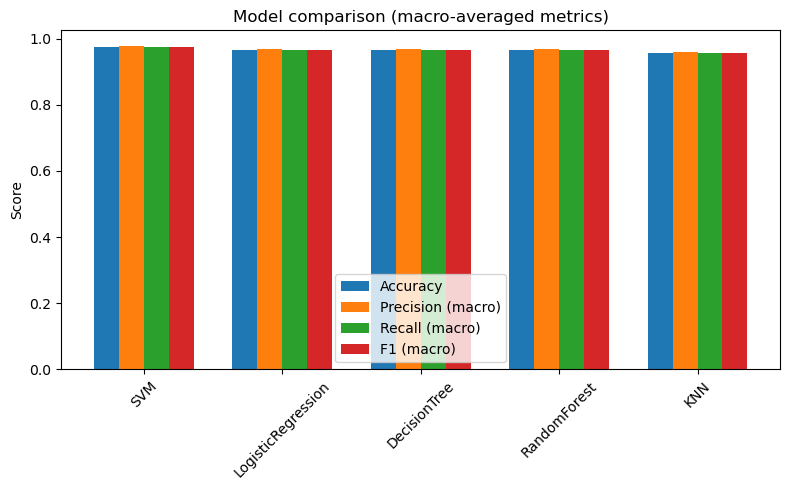

In [ ]:
import pandas as pd
results_df = pd.DataFrame(results).sort_values(by='f1_macro', ascending=False).reset_index(drop=True)
results_df

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
indices = np.arange(len(results_df))
width = 0.18
plt.bar(indices - 1.5*width, results_df['accuracy'], width, label='Accuracy')
plt.bar(indices - 0.5*width, results_df['precision_macro'], width, label='Precision (macro)')
plt.bar(indices + 0.5*width, results_df['recall_macro'], width, label='Recall (macro)')
plt.bar(indices + 1.5*width, results_df['f1_macro'], width, label='F1 (macro)')
plt.xticks(indices, results_df['model'], rotation=45)
plt.ylabel('Score')
plt.title('Model comparison (macro-averaged metrics)')
plt.legend()
plt.tight_layout()
plt.show()


## Closing notes
- Explain your preprocessing choices and discuss results.
- Optionally extend with hyperparameter tuning and cross-validation.
- Dataset file is available at the path shown above in the notebook environment.
